<a href="https://colab.research.google.com/github/aryan2107-cloud/100-Day-ML-Challenge-/blob/main/Day28_Hierarchial_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
plt.style.use('seaborn-v0_8-whitegrid')

## Part 1: How Hierarchical Clustering Works

**Agglomerative (bottom-up):**
1. Start: each point is its own cluster
2. Merge the two closest clusters
3. Repeat until one cluster remains
4. Cut the dendrogram at desired level

**Divisive (top-down):**
- Start with one cluster, split recursively
- Less common, more expensive

In [2]:

df = pd.read_csv("/content/Country-data[1].csv")

print(f"Dataset {df.shape[0]} countries, {df.shape[1]} columns")
df.head()

Dataset 167 countries, 10 columns


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [3]:
print("Features:")
descriptions = {
    'child_mort': 'Child mortality (per 1000 births)',
    'exports': 'Exports (% of GDP)',
    'health': 'Health spending (% of GDP)',
    'imports': 'Imports (% of GDP)',
    'income': 'Net income per person',
    'inflation': 'Inflation rate (%)',
    'life_expec': 'Life expectancy (years)',
    'total_fer': 'Fertility rate (children per woman)',
    'gdpp': 'GDP per capita'
}

for col, desc in descriptions.items():
  if col in df.columns:
    print(f" {col}: {desc}")

Features:
 child_mort: Child mortality (per 1000 births)
 exports: Exports (% of GDP)
 health: Health spending (% of GDP)
 imports: Imports (% of GDP)
 income: Net income per person
 inflation: Inflation rate (%)
 life_expec: Life expectancy (years)
 total_fer: Fertility rate (children per woman)
 gdpp: GDP per capita


In [4]:
print(f"Missing values:  {df.isnull().sum().sum()}")
df.describe().round(2)

Missing values:  0


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.00,167.00,167.00,167.00,167.00,167.00,167.00,167.00,167.00
mean,38.27,41.11,6.82,46.89,17144.69,7.78,70.56,2.95,12964.16
std,40.33,27.41,2.75,24.21,19278.07,10.57,8.89,1.51,18328.70
min,2.60,0.11,1.81,0.07,609.00,-4.21,32.10,1.15,231.00
25%,8.25,23.80,4.92,30.20,3355.00,1.81,65.30,1.80,1330.00
50%,19.30,35.00,6.32,43.30,9960.00,5.39,73.10,2.41,4660.00
75%,62.10,51.35,8.60,58.75,22800.00,10.75,76.80,3.88,14050.00
max,208.00,200.00,17.90,174.00,125000.00,104.00,82.80,7.49,105000.00


In [5]:
countries = df['country'].values
x = df.drop('country', axis=1).values
feature_names = df.drop('country', axis=1).columns.tolist()

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

print(f"features: {feature_names}")
print(f"Countries: {countries}")

features: ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']
Countries: ['Afghanistan' 'Albania' 'Algeria' 'Angola' 'Antigua and Barbuda'
 'Argentina' 'Armenia' 'Australia' 'Austria' 'Azerbaijan' 'Bahamas'
 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus' 'Belgium' 'Belize' 'Benin'
 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina' 'Botswana' 'Brazil' 'Brunei'
 'Bulgaria' 'Burkina Faso' 'Burundi' 'Cambodia' 'Cameroon' 'Canada'
 'Cape Verde' 'Central African Republic' 'Chad' 'Chile' 'China' 'Colombia'
 'Comoros' 'Congo, Dem. Rep.' 'Congo, Rep.' 'Costa Rica' "Cote d'Ivoire"
 'Croatia' 'Cyprus' 'Czech Republic' 'Denmark' 'Dominican Republic'
 'Ecuador' 'Egypt' 'El Salvador' 'Equatorial Guinea' 'Eritrea' 'Estonia'
 'Fiji' 'Finland' 'France' 'Gabon' 'Gambia' 'Georgia' 'Germany' 'Ghana'
 'Greece' 'Grenada' 'Guatemala' 'Guinea' 'Guinea-Bissau' 'Guyana' 'Haiti'
 'Hungary' 'Iceland' 'India' 'Indonesia' 'Iran' 'Iraq' 'Ireland' 'Israel'
 'Italy' 'Jamaica

## Part 3: Linkage Methods

How do we measure distance between clusters?

| Method | Distance Between Clusters |
|--------|---------------------------|
| **Single** | Minimum distance (nearest points) |
| **Complete** | Maximum distance (farthest points) |
| **Average** | Average of all pairwise distances |
| **Ward** | Minimizes within-cluster variance |

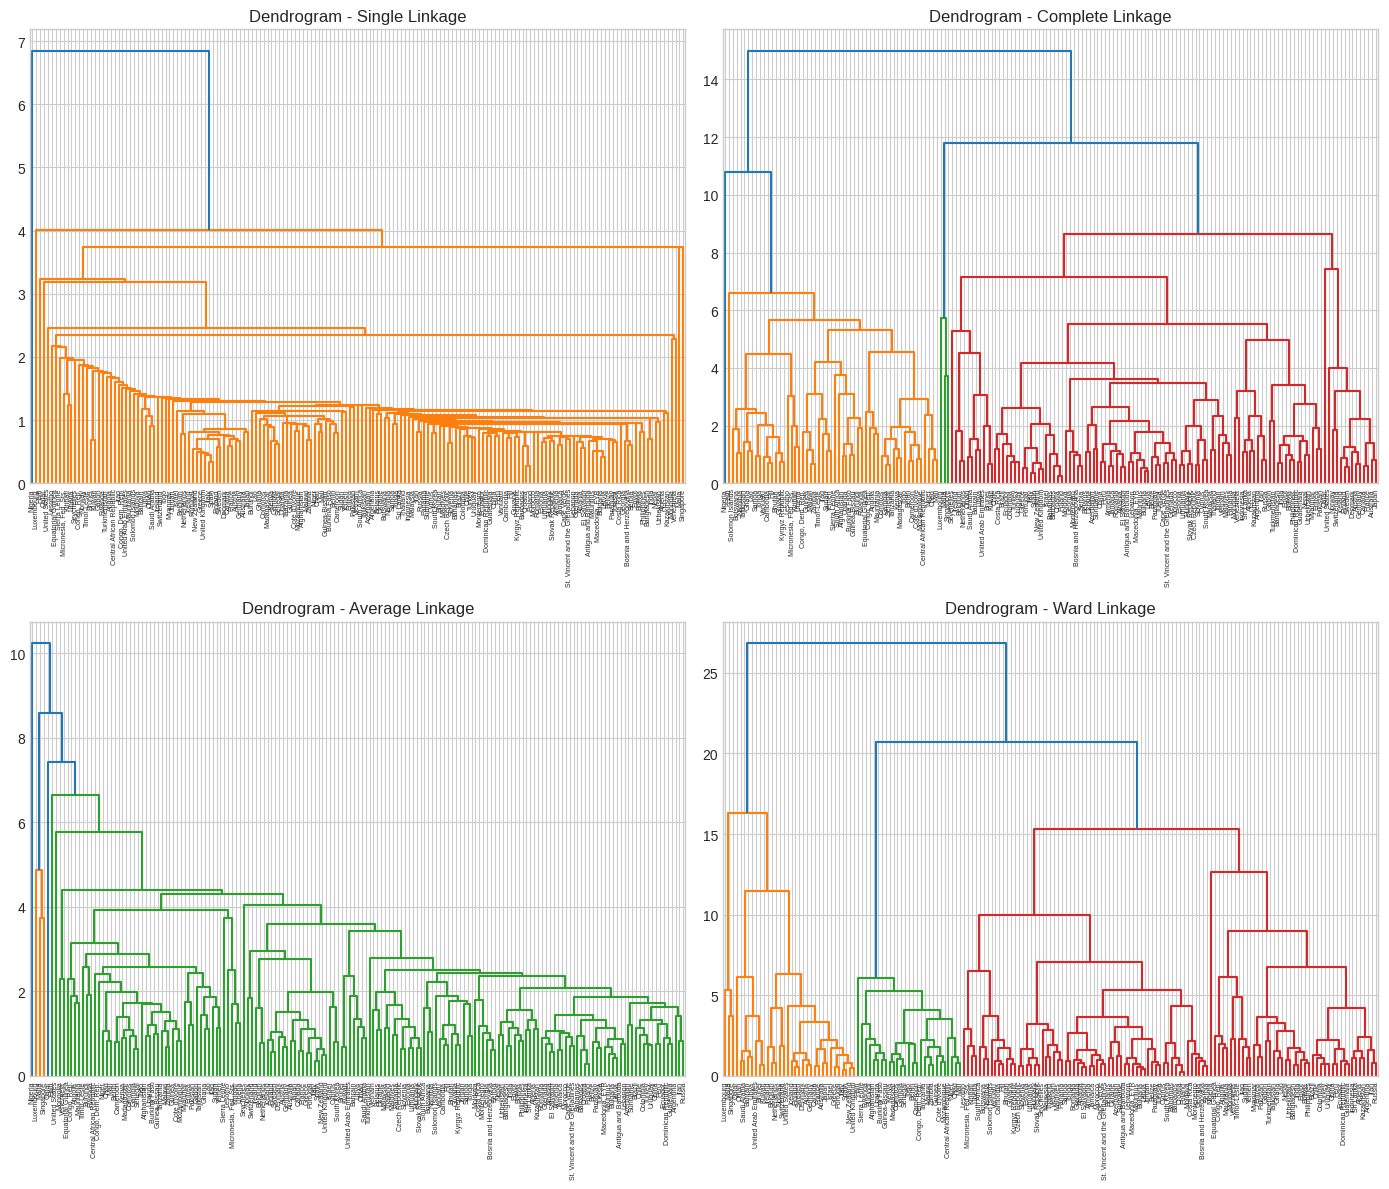

In [6]:
#comparing linkage methods
methods = ['single', 'complete', 'average', 'ward']

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for ax, method in zip(axes, methods):
  z = linkage(x_scaled, method=method)
  dendrogram(z, labels=countries, ax=ax, leaf_rotation=90)
  ax.set_title(f"Dendrogram - {method.capitalize()} Linkage")

plt.tight_layout()
plt.show()

In [7]:
print("Single: Can create 'chains' - elongated clusters")
print("Complete: Tends to create compact, equal-sized clusters")
print("Average: Compromise between single and complete")
print("Ward: Usually best for compact, spherical clusters")

Single: Can create 'chains' - elongated clusters
Complete: Tends to create compact, equal-sized clusters
Average: Compromise between single and complete
Ward: Usually best for compact, spherical clusters


Ward Linkage Dendogram

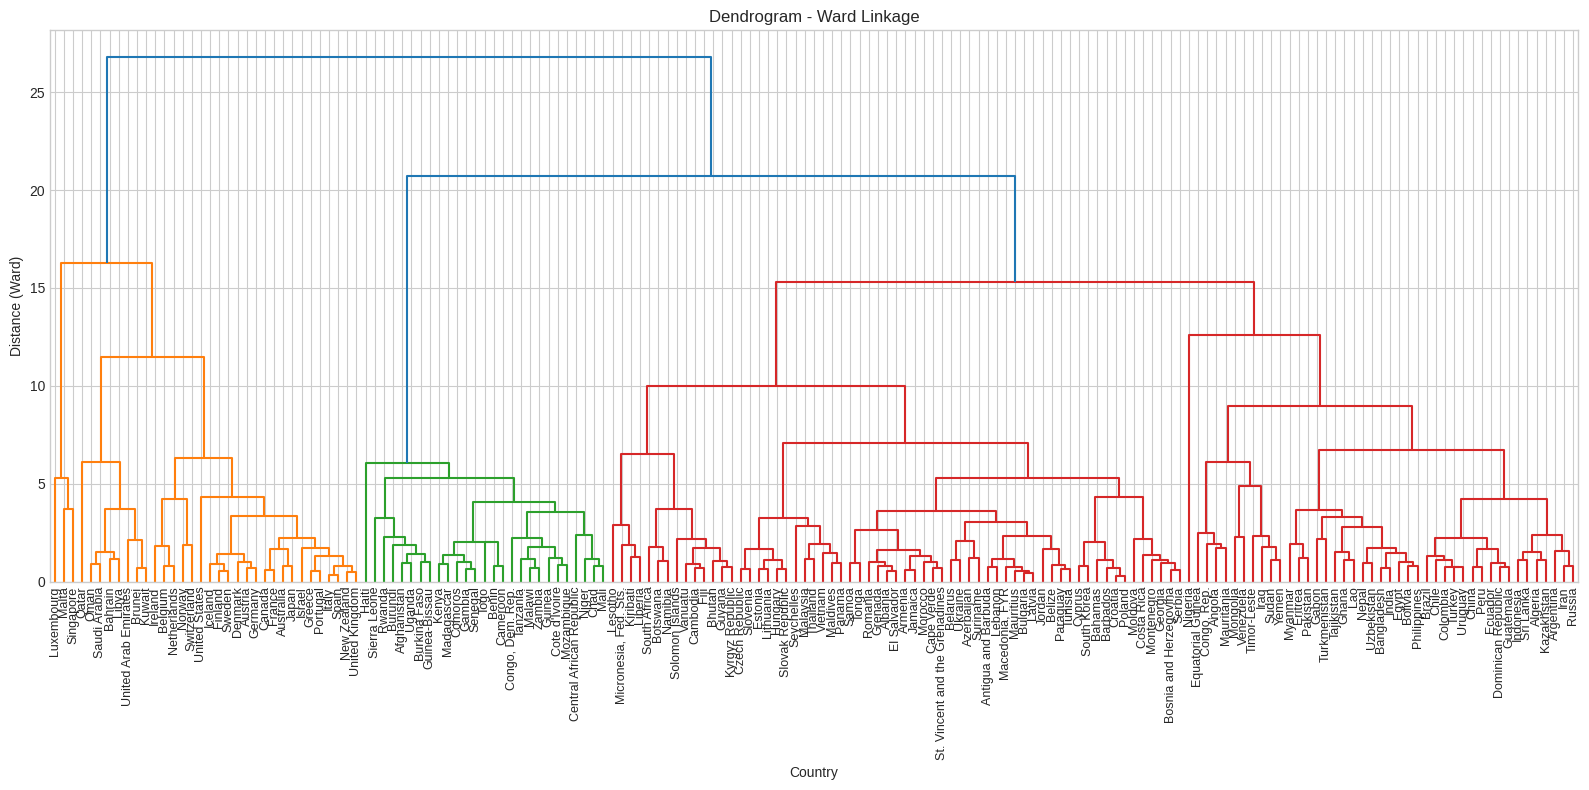

In [8]:
z_ward = linkage(x_scaled, method='ward')

plt.figure(figsize=(16, 8))
dendrogram(z_ward, labels=countries, leaf_rotation=90, leaf_font_size=9)
plt.title("Dendrogram - Ward Linkage")
plt.xlabel("Country")
plt.ylabel("Distance (Ward)")
plt.tight_layout()
plt.show()


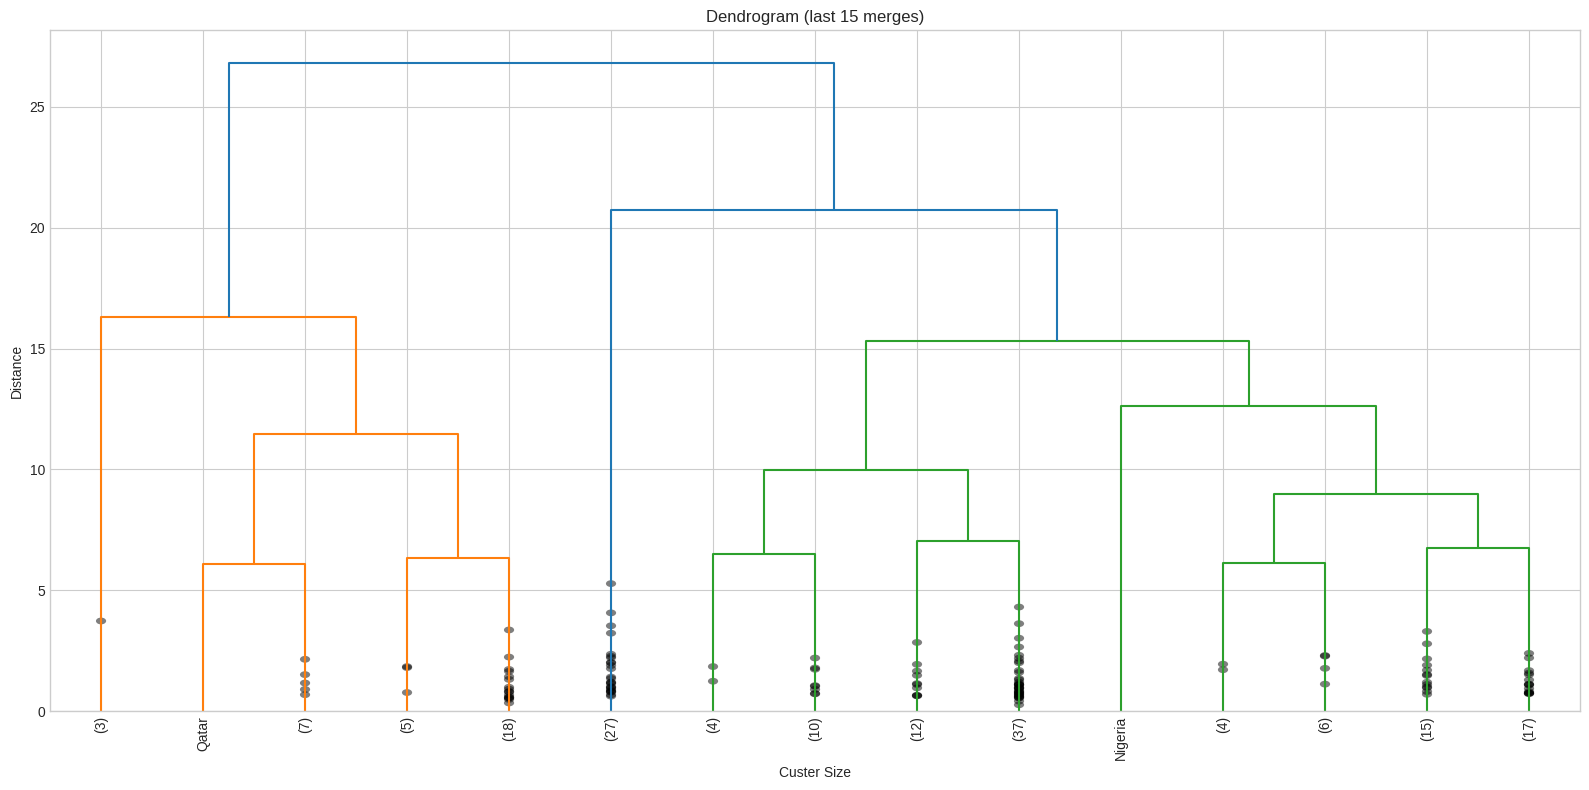

In [9]:
# A truncated dendogram
plt.figure(figsize=(16, 8))
dendrogram(z_ward, labels=countries, leaf_rotation=90, truncate_mode='lastp', p=15, leaf_font_size=10, show_contracted=True)
plt.title('Dendrogram (last 15 merges)')
plt.xlabel('Custer Size')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

Cutting the dendogram

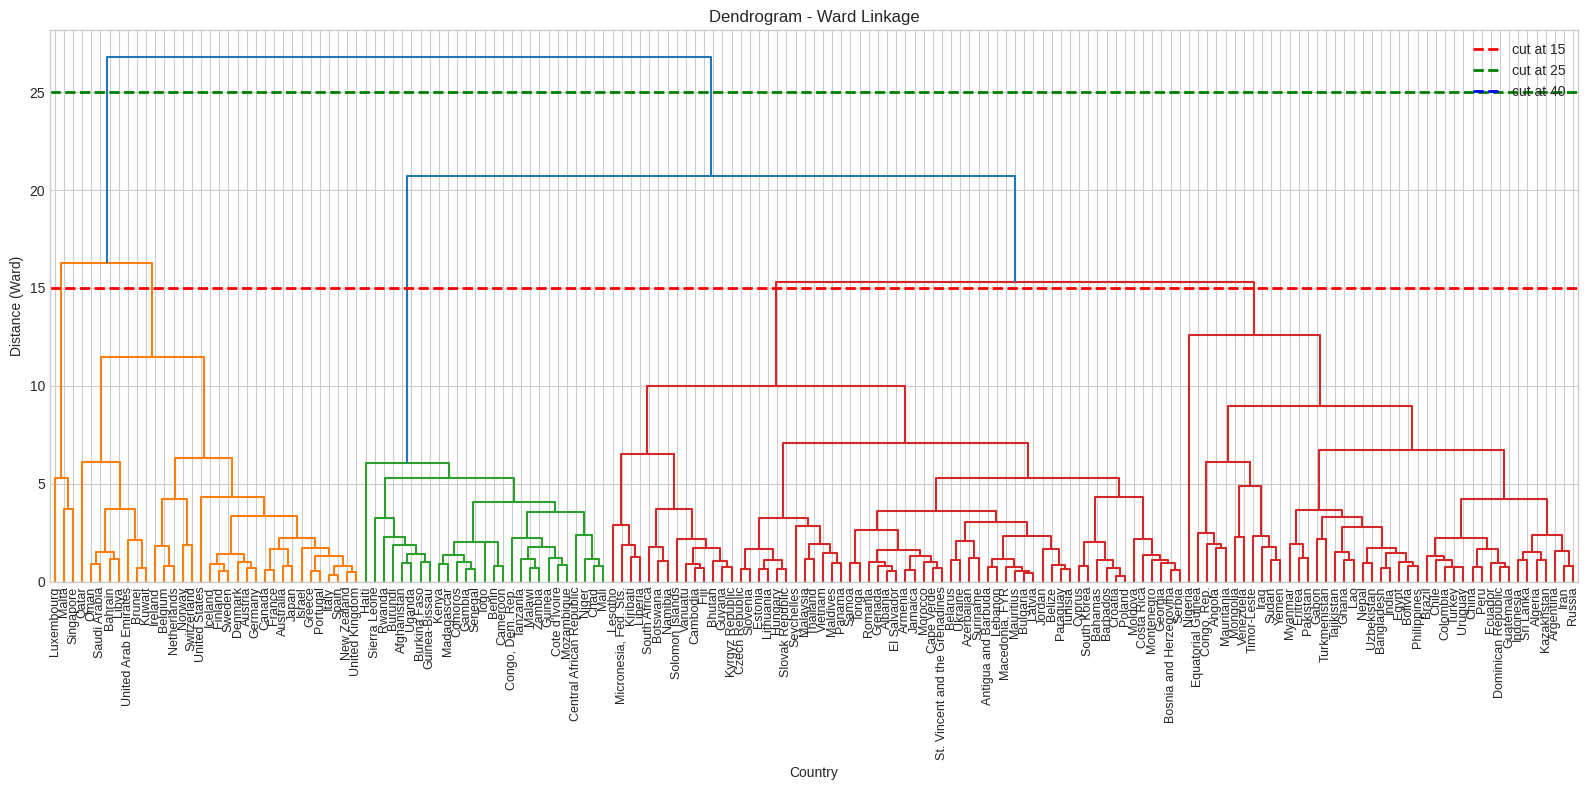

In [11]:
#Cutting at different angles
plt.figure(figsize=(16, 8))
dendrogram(z_ward, labels=countries, leaf_rotation=90, leaf_font_size=9)


cuts = [15, 25, 40]
colors = ['red', 'green', 'blue']
for cut, color in zip(cuts, colors):
  plt.axhline(y=cut, color=color, linestyle='--', linewidth=2, label=f'cut at {cut}')

plt.title("Dendrogram - Ward Linkage")
plt.xlabel("Country")
plt.ylabel("Distance (Ward)")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [12]:
for cut in cuts:
  labels =fcluster(z_ward, t=cut, criterion='distance')
  n_clusters = len(np.unique(labels))
  print(f"Cut at {cut}: {n_clusters} clusters")

Cut at 15: 5 clusters
Cut at 25: 2 clusters
Cut at 40: 1 clusters


Choosing number of clusters

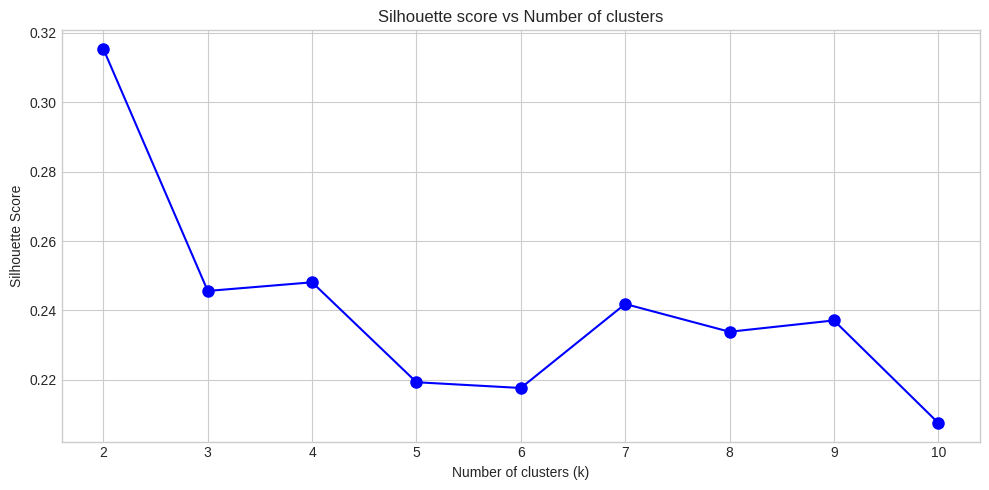

In [13]:
#Silhouette score for different numbers of clusters
k_range = range(2, 11)
silhouette_scores = []

for k in k_range:
  hc = AgglomerativeClustering(n_clusters=k, linkage='ward')
  labels = hc.fit_predict(x_scaled)
  score = silhouette_score(x_scaled, labels)
  silhouette_scores.append(score)

plt.figure(figsize=(10, 5))
plt.plot(k_range, silhouette_scores, 'b-o', markersize=8)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette score vs Number of clusters')
plt.xticks(k_range)
plt.tight_layout()
plt.show()

In [14]:
best_k = k_range[np.argmax(silhouette_scores)]
print(f"Best K by silhouette score: {best_k}")

Best K by silhouette score: 2


In [15]:
#Fitting the final model
n_clusters =3

hc = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
df['cluster'] = hc.fit_predict(x_scaled)

print(df['cluster'].value_counts().sort_index())

cluster
0     34
1    106
2     27
Name: count, dtype: int64


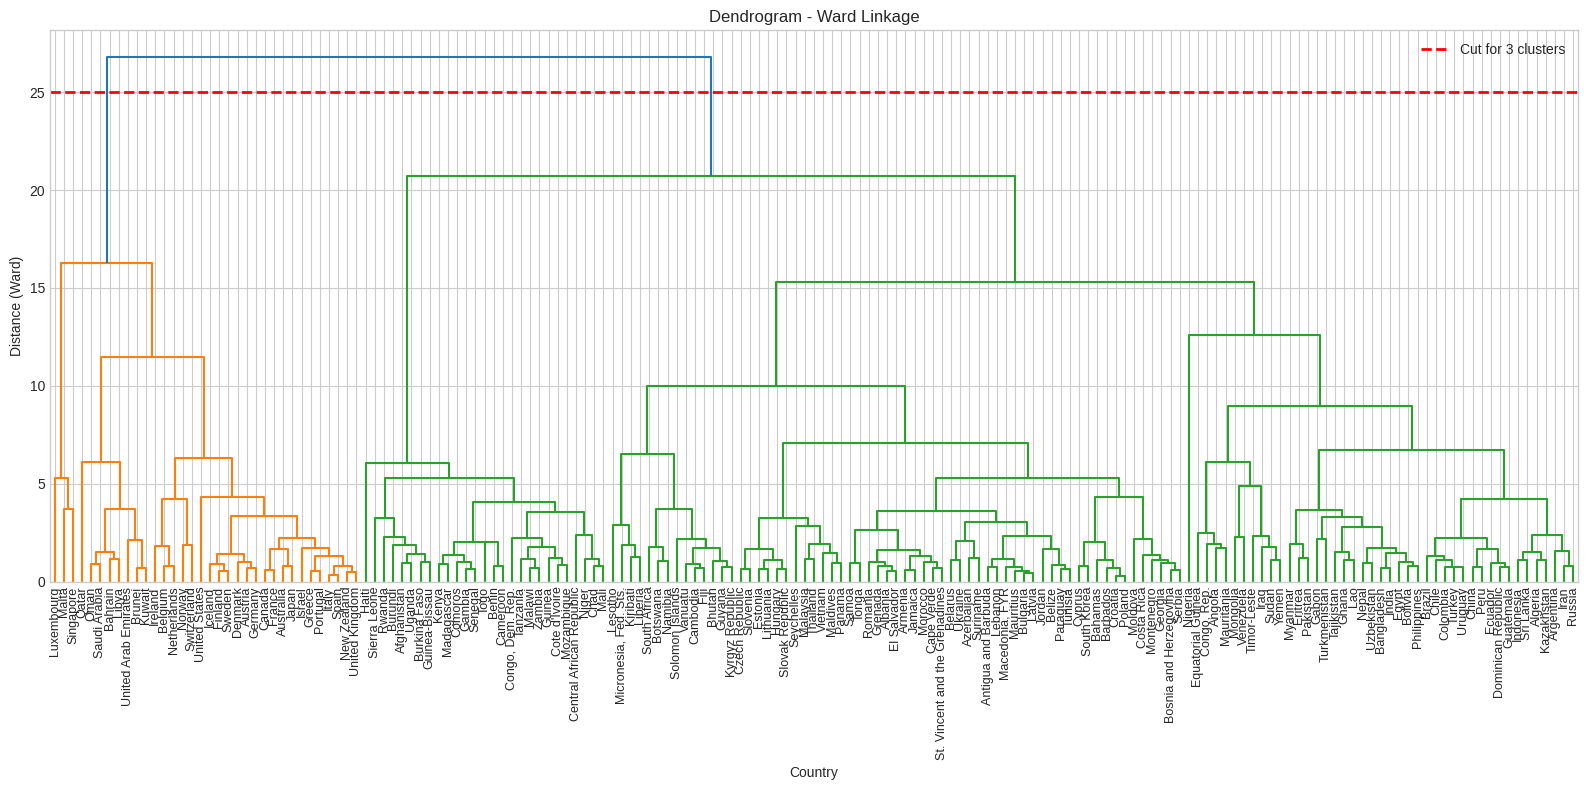

In [16]:
#Show dendrogram with cluster coloring
plt.figure(figsize=(16, 8))
dendrogram(z_ward, labels=countries, leaf_rotation=90, leaf_font_size=9, color_threshold=25)
plt.axhline(y=25, color='red', linestyle='--', linewidth=2, label='Cut for 3 clusters')
plt.title("Dendrogram - Ward Linkage")
plt.xlabel("Country")
plt.ylabel("Distance (Ward)")
plt.legend()
plt.tight_layout()
plt.show()

Comparing with K-means

In [19]:
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['KMeans_cluster'] = kmeans.fit_predict(x_scaled)

hc_silhouette = silhouette_score(x_scaled, df['cluster'])
km_silhouette = silhouette_score(x_scaled, df['KMeans_cluster'])

print(f"Hierarchical Clustering Silhouette Score: {hc_silhouette:.4f}")
print(f"K-means Clustering Silhouette Score: {km_silhouette:.4f}")

Hierarchical Clustering Silhouette Score: 0.2456
K-means Clustering Silhouette Score: 0.2856


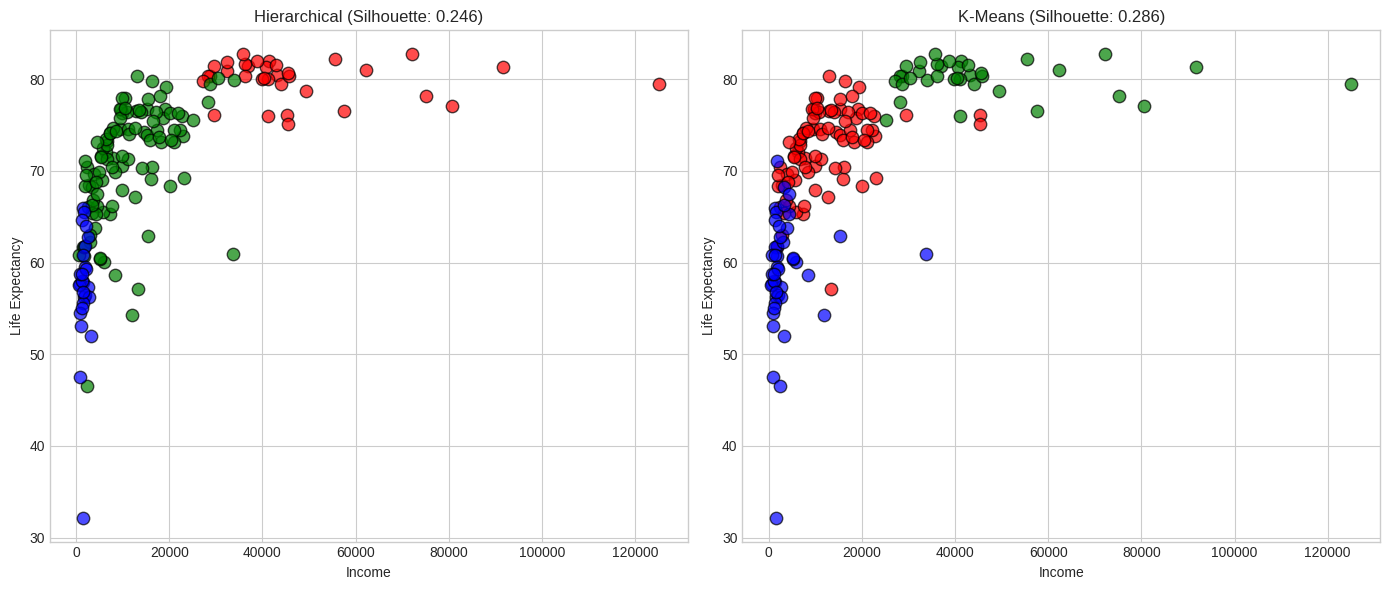

In [21]:
# Visual comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Hierarchical
for cluster in range(n_clusters):
    mask = df['cluster'] == cluster
    axes[0].scatter(df[mask]['income'], df[mask]['life_expec'],
                    c=colors[cluster], s=80, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Income')
axes[0].set_ylabel('Life Expectancy')
axes[0].set_title(f'Hierarchical (Silhouette: {hc_silhouette:.3f})')

# K-Means
for cluster in range(n_clusters):
    mask = df['KMeans_cluster'] == cluster
    axes[1].scatter(df[mask]['income'], df[mask]['life_expec'],
                    c=colors[cluster], s=80, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Income')
axes[1].set_ylabel('Life Expectancy')
axes[1].set_title(f'K-Means (Silhouette: {km_silhouette:.3f})')

plt.tight_layout()
plt.show()

In [23]:
# Compare distance metrics
metrics = ['euclidean', 'manhattan', 'cosine']

print(f"{'Metric':<12} {'Silhouette':<12}")
print("-" * 25)

for metric in metrics:
    if metric == 'cosine':
        # Ward doesn't work with cosine, use average
        hc_temp = AgglomerativeClustering(n_clusters=3, linkage='average', metric=metric)
    else:
        hc_temp = AgglomerativeClustering(n_clusters=3, linkage='ward')

    labels_temp = hc_temp.fit_predict(x_scaled)
    score = silhouette_score(x_scaled, labels_temp)
    print(f"{metric:<12} {score:<12.4f}")

Metric       Silhouette  
-------------------------
euclidean    0.2456      
manhattan    0.2456      
cosine       0.1852      


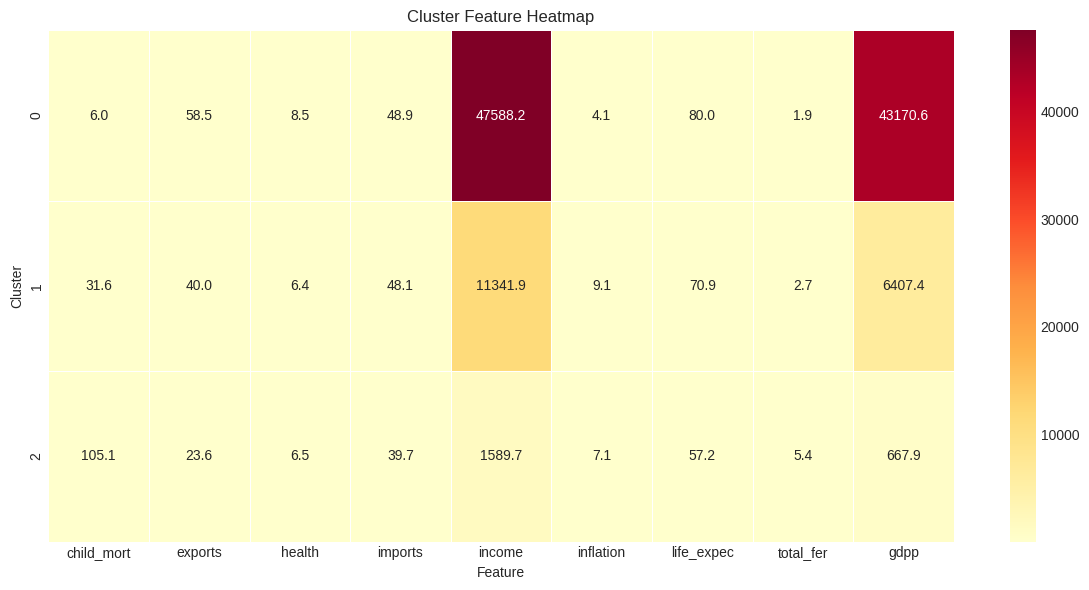

In [25]:
# Heatmap
cluster_profile = df.groupby('cluster')[feature_names].mean()
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_profile, annot=True, fmt='.1f', cmap='YlOrRd',
            linewidths=0.5)
plt.title('Cluster Feature Heatmap')
plt.xlabel('Feature')
plt.ylabel('Cluster')
plt.tight_layout()
plt.show()